<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/AnamolyDetectionIOCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np

In [11]:

# Parameters
rows = 100000  # large dataset
np.random.seed(42)

dates = pd.date_range(start="2022-01-01", periods=rows, freq="H")
units = ["CDU", "VDU", "DCU", "NCU", "Hydrocracker"]

data = {
    "date": np.random.choice(dates, rows),
    "unit_name": np.random.choice(units, rows),
    "electricity_kwh": np.random.normal(950, 120, rows).clip(400, 1600),
    "steam_usage": np.random.normal(500, 80, rows).clip(200, 900),
    "fuel_usage": np.random.normal(300, 60, rows).clip(100, 700),
    "production_tons": np.random.normal(120, 25, rows).clip(40, 200),
}

df = pd.DataFrame(data)

/tmp/ipython-input-2208272586.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2022-01-01", periods=rows, freq="H")


In [12]:

# Calculate SEC
df["SEC"] = (df["electricity_kwh"] + df["steam_usage"] + df["fuel_usage"]) / df["production_tons"]



In [13]:

# Inject anomalies (5%)
anomaly_indices = np.random.choice(df.index, size=int(0.05 * rows), replace=False)
df.loc[anomaly_indices, "electricity_kwh"] *= np.random.uniform(1.4, 1.8)
df.loc[anomaly_indices, "SEC"] *= np.random.uniform(1.3, 1.7)

In [14]:
# Save dataset
file_path = "/content/refinery_energy_large_dataset.csv"
df.to_csv(file_path, index=False)
file_path

'/content/refinery_energy_large_dataset.csv'

In [15]:
df.head()


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC
0,2023-10-21 03:00:00,Hydrocracker,876.896024,451.883508,315.944364,129.774212,12.673734
1,2022-02-05 20:00:00,CDU,892.363227,583.108650,366.385274,151.946967,12.121711
2,2030-10-06 20:00:00,DCU,1038.607058,554.011159,157.918743,136.168087,12.855707
3,2028-04-05 22:00:00,CDU,808.311888,680.183209,304.637560,138.340267,12.961755
4,2022-09-19 01:00:00,CDU,997.376810,490.170735,337.180859,141.055837,12.936213


In [16]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             100000 non-null  datetime64[ns]
 1   unit_name        100000 non-null  object        
 2   electricity_kwh  100000 non-null  float64       
 3   steam_usage      100000 non-null  float64       
 4   fuel_usage       100000 non-null  float64       
 5   production_tons  100000 non-null  float64       
 6   SEC              100000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.3+ MB


,date,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2027-09-12 14:14:58.668000,972.437356,499.851132,300.129255,119.871217,15.846840
min,2022-01-01 01:00:00,415.212862,200.000000,100.000000,40.000000,6.500047
25%,2024-10-23 03:30:00,874.636672,445.939366,259.409521,103.059587,12.742459
50%,2027-09-14 16:30:00,958.248170,499.721193,300.145832,119.938715,14.806698
75%,2030-07-27 00:45:00,1046.315425,553.608806,340.799157,136.807303,17.695516
max,2033-05-29 13:00:00,2002.239589,848.946410,590.107246,200.000000,79.222977
std,NaN,155.714613,79.996411,60.307704,24.965763,4.754760


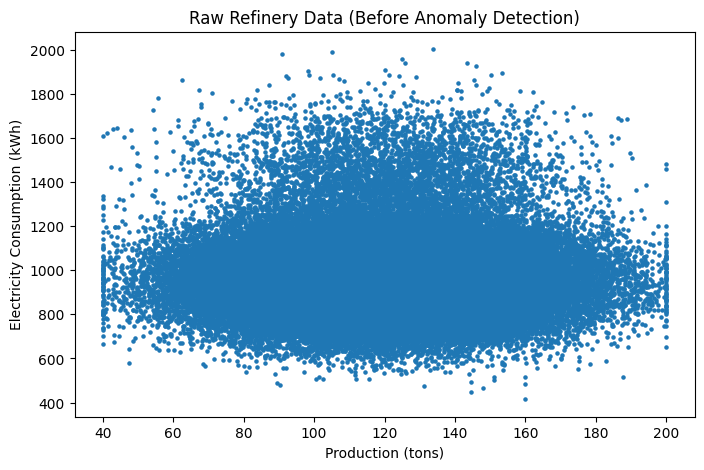

In [17]:
# Visualize RAW DATA
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df["production_tons"], df["electricity_kwh"], s=5)
plt.xlabel("Production (tons)")
plt.ylabel("Electricity Consumption (kWh)")
plt.title("Raw Refinery Data (Before Anomaly Detection)")
plt.show()


ANOMALY DETECTION

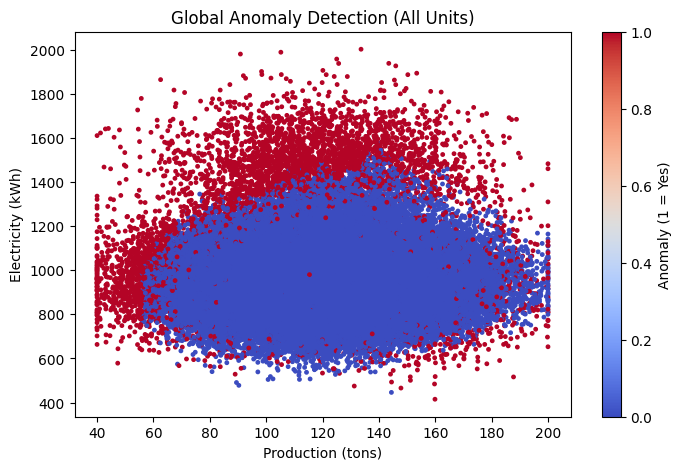

In [19]:
# ------------- Feature selection ------------
from sklearn.ensemble import IsolationForest

features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]

# Train ONE global model

global_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

global_model.fit(X)

# Predict & STANDARDIZE anomaly column
df["anomaly"] = np.where(global_model.predict(X) == -1, 1, 0)

# Visual: Global anomaly overview


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(
    df["production_tons"],
    df["electricity_kwh"],
    c=df["anomaly"],
    cmap="coolwarm",
    s=6
)
plt.xlabel("Production (tons)")
plt.ylabel("Electricity (kWh)")
plt.title("Global Anomaly Detection (All Units)")
plt.colorbar(label="Anomaly (1 = Yes)")
plt.show()


# ------------UNIT-WISE ANOMALY DETECTION-----------


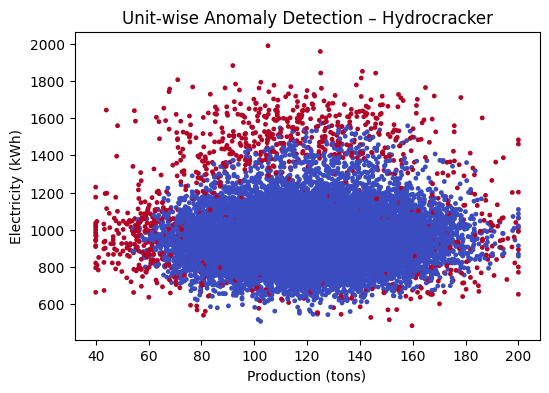

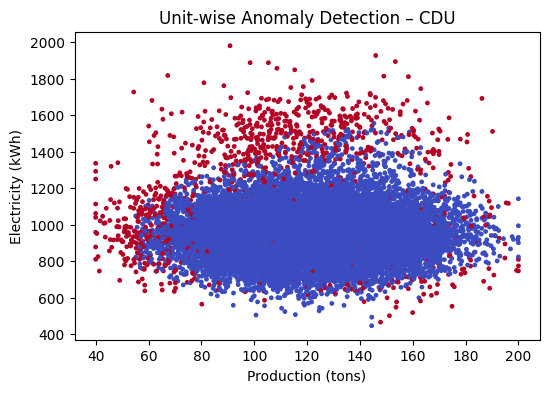

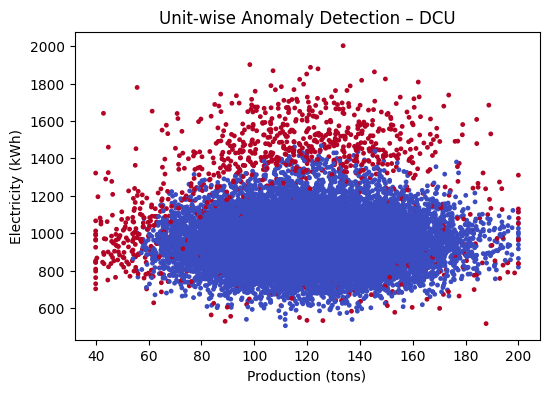

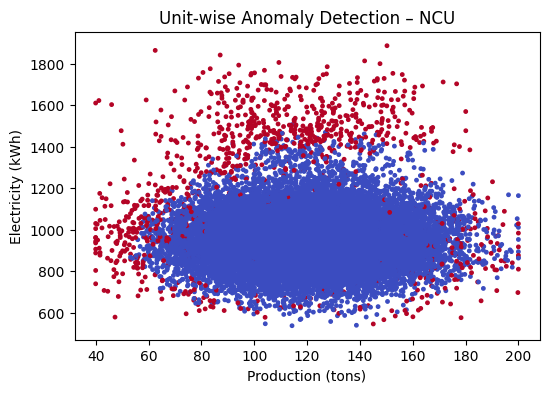

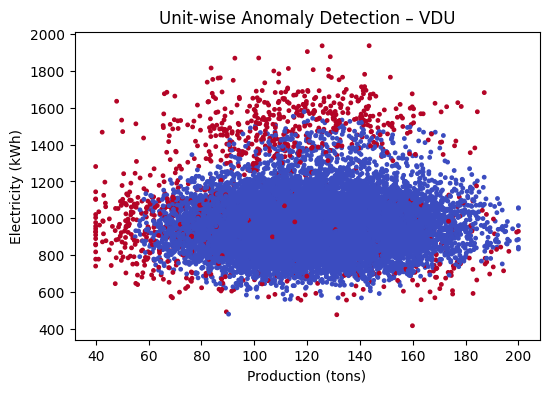

In [23]:
# Split data unit-wise
unit_dfs = {
    unit: df[df["unit_name"] == unit].copy()
    for unit in df["unit_name"].unique()
}


# Train Isolation Forest per unit

unit_models = {}

for unit, unit_df in unit_dfs.items():
    model = IsolationForest(
        n_estimators=100,
        contamination=0.05,
        random_state=42
    )
    model.fit(unit_df[features])
    unit_models[unit] = model


# Detect anomalies unit-wise
for unit, unit_df in unit_dfs.items():
    preds = unit_models[unit].predict(unit_df[features])
    unit_df["anomaly"] = np.where(preds == -1, 1, 0)
    unit_dfs[unit] = unit_df

# Visual per unit

for unit, unit_df in unit_dfs.items():
    plt.figure(figsize=(6,4))
    plt.scatter(
        unit_df["production_tons"],
        unit_df["electricity_kwh"],
        c=unit_df["anomaly"],
        cmap="coolwarm",
        s=6
    )
    plt.title(f"Unit-wise Anomaly Detection – {unit}")
    plt.xlabel("Production (tons)")
    plt.ylabel("Electricity (kWh)")
    plt.show()


------------ ALERT SEVERITY CALCULATION -------------

In [25]:
# Severity function
SEC_mean = df["SEC"].mean()

def calculate_severity(row):
    if row["SEC"] > 1.5 * SEC_mean:
        return "HIGH"
    elif row["SEC"] > 1.2 * SEC_mean:
        return "MEDIUM"
    else:
        return "LOW"


# Apply severity ONLY on anomalies
for unit, unit_df in unit_dfs.items():
    unit_df["severity"] = np.where(
        unit_df["anomaly"] == 1,
        unit_df.apply(calculate_severity, axis=1),
        "NORMAL"
    )
    unit_dfs[unit] = unit_df


------CREATE ALERT REPORT----

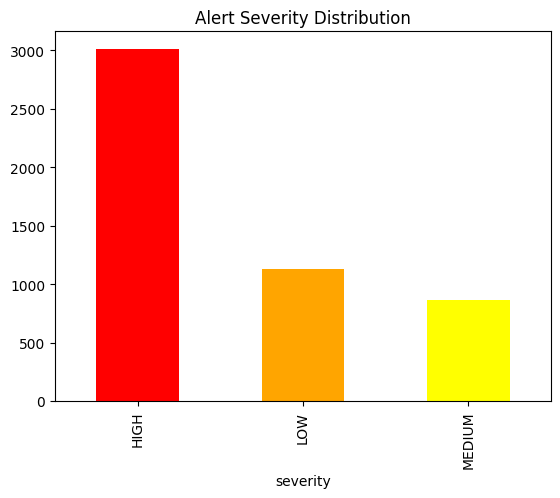

In [26]:
alert_records = []

for unit, unit_df in unit_dfs.items():
    anomalies = unit_df[unit_df["anomaly"] == 1]

    for _, row in anomalies.iterrows():
        alert_records.append({
            "unit": unit,
            "date": row["date"],
            "severity": row["severity"],
            "message": f"Abnormal SEC detected in {unit}"
        })

alerts_df = pd.DataFrame(alert_records)
alerts_df.head()

# Severity distribution
alerts_df["severity"].value_counts().plot(
    kind="bar",
    title="Alert Severity Distribution",
    color=["red","orange","yellow"]
)
plt.show()


SEND ALERT REPORT TO GMAIL

In [28]:
# Create CSV report
alert_file = "refinery_alert_report.csv"
alerts_df.to_csv(alert_file, index=False)

# Send email
import smtplib
from email.message import EmailMessage

EMAIL = "dharambaba2k4@gmail.com "
APP_PASSWORD = "fugmkuhfxtzeutjm"

msg = EmailMessage()
msg["Subject"] = " Refinery Energy Anomaly Alert Report"
msg["From"] = EMAIL
msg["To"] = "dharamcodemystery@gmail.com"
msg.set_content("Attached is the refinery anomaly alert report.")

with open(alert_file, "rb") as f:
    msg.add_attachment(
        f.read(),
        maintype="application",
        subtype="octet-stream",
        filename=alert_file
    )

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(EMAIL, APP_PASSWORD)
    server.send_message(msg)

print("Alert email sent successfully!")


Alert email sent successfully!
